### Introduction to Keras Functional API
keras is a deep learning API that can run on a computation back such as tensor flow or theano.  This allows a much more readable system for creating, traning and deploying 
+ Keras has two API (functional and sequential)
This into uses the functional API

##### Creating a keras model
Keras models are comprised of the following components

+ Architecture:
    + Inputs
    + Layers
        + Initializers 
        + Activation Functions
    + Outputs

+ Loss Function (how to calculated error when the model is training for each row )
+ Optimizer (how weights are adjusted after the error is calculated)
+ Metrics (batch wise  over all statistics during training)
+ Callbacks (extra steps during training to monitor progress optional)


In [33]:
# loads a data set
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split


import warnings 
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    from keras.layers import Input, Dense, BatchNormalization
    from keras.models import Model
    from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
    import keras.backend as K
    from keras.utils import to_categorical

np.random.seed(2012)
bc = load_breast_cancer()
feature_names = bc.feature_names
X_train, X_test, y_train, y_test = train_test_split(bc.data, bc.target, random_state=2012)

X_train.shape, y_train.shape


((426, 30), (426,))

#### Set Up Inputs Using Keras Input Layer

keras Input shape as an argument where shape tuple of integers. This is tpyically refered to as the 'input_layer'

+ 2D, (rows, columns)  for data with num_samples and n_features, ```Input(shape=( n_features,))```

    This means the the network is expecting an array with shape (num_samples,  n_features), each batch will be a subset of rows


+ 3D Inputs such as time sequences ```Input(shape=(time_steps, n_features)```

    This means the model would expect input of the shape(n_samples, time_steps, n_features)
    an example of this would be a data set 10 sequential observations of pulse and temp for 50 patients would have shape
    (50, 10, 2), batches would be a subset of patients


+ 4D Data Such as Images ```Input(shape=(width, height, n_color_channels))```
The data input expect for this scheme would be of the shape (n_samples, width, height, n_color_channels) where the batches are taken from a subset of sample images


In [2]:
# get the number of columns of the input data
n_input_cols = X_train.shape[1]

# sets up the input shape expectation for the model
inputs = Input(shape=(n_input_cols,))

#### Layers 
There are many types of keras layers. The most common is a Dense Layer.
+ BatchNormalizationLayer: takes data from previous layer, try to keep mean 0 stdev 1 
    + maintains weights that are trainable for this transformation
    + takes input from previous layer, attempts to scale each input it to mean 0 stdev 1

+ Dense Layers have a number of nodes, 
   +  ``` Dense(5)```  uses default intializer for weights and bias, has 5 hidden nodes
    + maintains weights, and biases that are trainable
    + multiplies a different wieght for each input for each node, add bias and sums
    + takes that value and puts it through an activation function, such as Relu or TANH
    
##### Initializers
In a dense layer, the weights (kernal) need to be initialized some how, either choosen from a random normal distrobution at random, set to all zeros or most typically choosen from the 'glorot_uniform' distrobution

##### Activation Functions
Activation functions are applied at each node to additionally transform the data.  The most typical is relu {x: x <0 then 0 else x}

In [3]:

# add normalization layer mean activation close to 0 and the activation standard deviation close to 1.
normalization_layer = BatchNormalization()(inputs)

# add a hidden Layer with 5 hidden notes
hidden_layer = Dense(5, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros')( normalization_layer)


#### Outputs 
The output layer of the network is typically just another Dense Layer with an activation function that matches your prediction problem
+ Number of nodes must match number of columns of your outcomes

##### Classication
 + Classication where lables are an array of integer classes, is [1,0,1,0, 0 ..]
      + ```outputs = Dense(1, activation='sigmoid')(hidden_layer)```
      + when calling model.compile, use ```loss = 'binary_crossentropy'```
 + Classication where labels are one hot encododed [[1, 0], [0,1], ...]
      + ```outputs = Dense(num_label_columns, activation='sigmoid')(hidden_layer)```
      + when calling model.compile, use ```loss = 'categorical_crossentropy'```
 + Mulit Class Classication where labels are a list of integer classes [1,2,0,4, ... ]
      + ```outputs = Dense(num_classes, activation='sigmoid')(hidden_layer)```
      + when calling model.compile, use ```loss = 'sparse_categorical_crossentropy'```
 + Activation:
     + 'sigmoid': when actually probabilities are important
     + 'softmax': when only classication accuracy is important
     
##### Regression
  + ```outputs = Dense(num_output_columns, activation='linear')(hidden_layer)```
  + when calling model.compile, use ```loss = 'mean_squared_error'``` or similiar 
   

In [4]:

# create ouput layer of the model  
outputs = Dense(1, activation='sigmoid')(hidden_layer)
model = Model(inputs=inputs, outputs=outputs)


#### Compline the model meas assembling it together and defining a loss function and optimizer and any callbacks
+ Optimizer is the method of that adjusts each weight given the Loss calcuated at the end of each batch
    + typicaly choose 'adam' or 'Nadam'
    
+ Loss Function is how the model will calculated error for each sample, entropy based for classication and error based for the regression 
+ Metrics are calculated on batches of data (like AUC or correlation)


In [5]:
# Compile the model 
esm = EarlyStopping(monitor='val_loss', min_delta=0, patience=0)
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 155       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 281
Trainable params: 221
Non-trainable params: 60
_________________________________________________________________


#### Call Backs 
Call backs are esentially methods that run after each step.  The could send the results to tensorboard, save and check point the model, or in this case stop training if the model fails to improve

+ EarlyStopping monitors the loss function, if it fails to improve in 2 batches, the model stops training
+ ModelCheckpoint saves only the weights if the metric improves 
+ ReduceLROnPlateau reduces the learning rate when the metric plateaus


In [6]:
epochs = 20

# intial learning rate
learning_rate = .01

# factor to reduce learning rate on plateau
lrPlateauReductionFactor = .5

# minimum learning rate
lrMin = 0.0001
weights_path = "weights_best.hdf5"
patience = 5
metric =  'val_accuracy'


# adjusts the learing rate
K.set_value(model.optimizer.lr,learning_rate)

# sets an early stopping callback
esm =  EarlyStopping(patience=patience, monitor=metric )

# saves only the best weights
checkpoint = ModelCheckpoint(weights_path ,mode='max', monitor=metric, verbose=0, save_best_only=True)

# reduces learning rate on performance platu
lrReducer = ReduceLROnPlateau(monitor=metric, factor=lrPlateauReductionFactor, min=lrMin)


#### Training
the .fit method is call on a X,y
+ batch size is the number of rows sampled from x used to calcuated loss, and adjust weights
+ validation_data is a tuple of (X,y) test data in which metrics and loss are callculated during each step
+ epochs is the number of passed through the entire data set
+ callbacks are a list of callback objects

In [7]:
model.fit(X_train, y_train, validation_data=(X_test, y_test),  
          batch_size=32, 
          epochs=epochs,  callbacks=[esm, checkpoint, lrReducer])


Train on 426 samples, validate on 143 samples
Epoch 1/20
426/426 [==============================] - 0s 827us/step - loss: 0.3029 - accuracy: 0.9108 - val_loss: 7.0827 - val_accuracy: 0.3217
Epoch 2/20
426/426 [==============================] - 0s 102us/step - loss: 0.1489 - accuracy: 0.9531 - val_loss: 7.8954 - val_accuracy: 0.3217
Epoch 3/20
426/426 [==============================] - 0s 92us/step - loss: 0.1192 - accuracy: 0.9460 - val_loss: 7.1744 - val_accuracy: 0.3217
Epoch 4/20
426/426 [==============================] - 0s 118us/step - loss: 0.1546 - accuracy: 0.9460 - val_loss: 4.7748 - val_accuracy: 0.3217
Epoch 5/20
426/426 [==============================] - 0s 97us/step - loss: 0.0965 - accuracy: 0.9671 - val_loss: 3.9736 - val_accuracy: 0.3217
Epoch 6/20
426/426 [==============================] - 0s 123us/step - loss: 0.0875 - accuracy: 0.9695 - val_loss: 3.2028 - val_accuracy: 0.3357
Epoch 7/20
426/426 [==============================] - 0s 103us/step - loss: 0.1141 - accurac

#### Model Understanding Using Shap Values

Basic understanding on by predictions are being made is oftne a requirment orf the model.  The following uses shap values to calcuate feature contributions at the row level for any genaric function using shap Kernal Explainer


This based on resample the data, and nsamples times, so it is computational expensive

[https://github.com/slundberg/shap]

In [55]:
import shap

explainer = shap.KernelExplainer(model.predict, X_train, feature_names=feature_names)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(X_test, nsamples=10)[0]

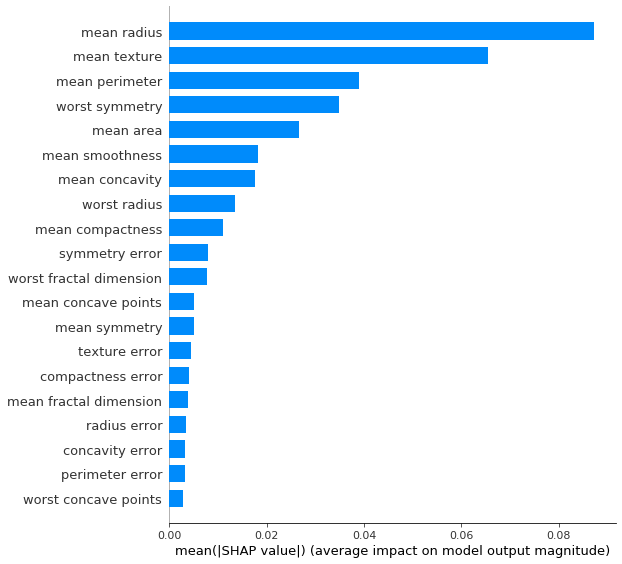

In [56]:
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_names)

In [ ]:
#### Contributions of Indivual Features

(143, 30)

<Figure size 432x288 with 0 Axes>

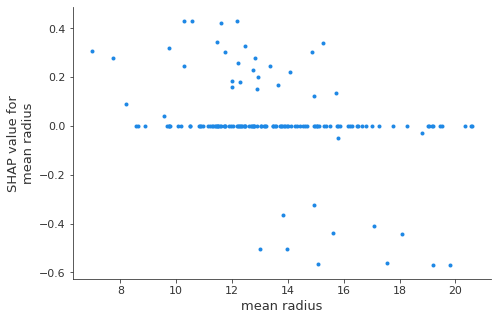

In [62]:
from matplotlib import pyplot as plt
plt.figure()
shap.plots.dependence.dependence_plot('mean radius', shap_values, X_test, feature_names, interaction_index=None )
plt.show()
display()

#### Model Persistance
Saving and reloading the model this show saving the entire model 

In [9]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')
model.predict(X_test)[0:3, :]

array([[0.98319626],
       [0.9605296 ],
       [0.71251357]], dtype=float32)

#### Model Persistance
This save the architechel to json and weights seperately.

In [20]:

# model reconstruction from JSON:
from keras.models import model_from_json
import json

# save as JSON
json_string = model.to_json()
with open('my_model.json', 'w') as f:
    json.dump(json_string, f)

# save weights
model.save_weights('my_model_weights.h5')

del model
del json_string


# model reconstruction from JSON:
from keras.models import model_from_json
with open('my_model.json', 'r') as f:
    json_string = json.load(f)
model = model_from_json(json_string)
model.load_weights('my_model_weights.h5')
model.predict(X_test)[0:3, :]


array([[0.98319626],
       [0.9605296 ],
       [0.71251357]], dtype=float32)